<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/NLP_Tesla_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отслеживание окраски отзывов на примере автомобиля Тесла

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, SimpleRNN, Concatenate, Input, concatenate, LSTM, Embedding, BatchNormalization, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import io
import re
from google.colab import drive
import sklearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/NLP course/Данные/'
!ls

# Парсим отзывы про Тесла

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
color_meaning = {'00ff00':'сравнение', '00ffff':'дальность', '9900ff':'эмоции', 'ff00ff':'комфорт', 'ffff00':'скорость',
                'green':'сравнение', 'yellow':'скорость', 'cyan':'дальность', 'magenta':'комфорт'} #создаем словарь соответствий цвет-значение

In [ ]:
#названия необходимых тегов
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

In [ ]:
#парсим tesla_1
tree = ET.parse('tesla_1.xml')
root = tree.getroot()
body = root[0]
ps1 = list(iter(body))[:2497]

In [ ]:
#парсим tesla_2
tree = ET.parse('tesla_2.xml') #открываем xml файл
root = tree.getroot() #находим корень
body = root[0]
ps2 = list(iter(body))[:2481] #получаем список всех отзывов

In [ ]:
#Сведем все в кучу для токенайзера
all_txt=[]

for paragraph in ps1: # отзывы из 1 блока
    phrases_list = paragraph.findall(r)
    text=''
    for phrase in phrases_list:
        text+= phrase.find(t).text
    all_txt.append(text)

for paragraph in ps2: # отзывы из 2 блока
    phrases_list = paragraph.findall(r)
    text=''
    for phrase in phrases_list:
        text+= phrase.find(t).text
    all_txt.append(text)

print('Количество отзывов:', len(all_txt))
all_txt[3]

Количество отзывов: 4978


'+-Машина на любителя. Назвать мягкой её сложно. Двери открывающиеся вверх неудобны.\xa0'

In [ ]:
# PyMorphy используем для нормализации форм слов (чтобы не раздувать num_character, а соответственно Embedding)
!pip install pymorphy2 
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
# Пересобираем текст в нормальной форме
def morphy_clean(text):
  '''
  функция возвращает list слов в нормальной форме, в расчёт не берём "NUMR - числительное, PREP - предикатив, CONJ - предлог, PRCL - союз, INTJ - частица или междометие" 
  '''
  for i in range(len(text)):
    # генератор перебирает слова внутри i-го предложения, собираем через пробел в строку
    text[i]=' '.join([morph.parse(word.replace('.',''))[0].normal_form for word in text[i].split() if morph.parse(word.replace('.',''))[0].tag.POS not in ('NUMR','PREP','CONJ','PRCL','INTJ')])
  return text

In [ ]:
# смешно, но как будто пишет человек иностранец, не знающий русский язык )))
all_txt = morphy_clean(all_txt)
all_txt[3]

'+-машина любитель назвать мягкий её сложно дверь открываться вверх неудобный'

In [ ]:
# создаем словарь частотности по всему тексту исключая знаки
num_characters = 12000
tokenizer = Tokenizer(num_words=num_characters, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token='<unk>') #токенизируем на уровне слов
tokenizer.fit_on_texts(np.array(all_txt)) #формируем токены на основе частотности в нашем тексте
tok_ind = tokenizer.word_index # выводим сколько всего уникальных слов
print(len(tok_ind))
[_ for _ in tok_ind.items() if _[0] in ['машина', 'колесо', 'скорость', 'сиденье', 'спортивный', 'руль']] # генератор по словарю, по нескольким ключам

11692


[('машина', 3),
 ('скорость', 81),
 ('руль', 89),
 ('колесо', 172),
 ('спортивный', 908),
 ('сиденье', 3282)]

In [ ]:
# создаём словарь оценок
index_color = {'сравнение':0,
               'дальность':1,
               'эмоции':2,
               'комфорт':3,
               'скорость':4}

In [ ]:
# из текста в ворде нам необходимо выделить фразы в которых есть семантическая окраска
Train = {}
X_train = []
Y_train = []

In [ ]:
# функция парсинга текста
def parsing_doc(doc2txt):
  Train = {} # словарь текст-оценка
  X_train = []
  Y_train = []
  semant_index = [0, 0, 0, 0, 0]

  for i, paragraph in enumerate(doc2txt): #проходим по всем отзывам
      phrases_list = paragraph.findall(r) #находим все фразы (часть отзыва) 
      
      text_temp = ''
      meaning_temp = ''
      for j, phrase in enumerate(phrases_list): #проходим по всем фразам
          
          text = phrase.find(t).text #получаем текст, содержащийся во фразе
          ###
          text = ' '.join(morphy_clean(text.split(' ')))  # текст приводим к нормальной форме
          text_temp += text
          ###
          style = phrase.find(rpr) #получаем стили фразы
        
          if style.find(shd) is not None: #если размечали через заливку
              color = style.find(shd).attrib[fill] #получаем значение цвета заливки
          elif style.find(highlight) is not None: #если размечали через хайлайт
              color = style.find(highlight).attrib[val] #получаем значение цвета хайлайта
          else:
              color = 'white' #иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
          color = color.lower() #переводим строковое значение цвета в нижний регистр
          meaning = color_meaning[color] if color in color_meaning else '' #если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
          #colors.add(color) добавляем цвет в словарь всех встреченных цветов, если нужно проанализировать их

          ###
          if meaning in index_color.keys():
            semant_index[index_color[meaning]] = 1            
          ###

          #print(text, '[{0}]'.format(meaning))
      X_train.append(text_temp)
      Y_train.append(semant_index)

      Train[text_temp] = semant_index

      semant_index = [0, 0, 0, 0, 0]
  return Train, X_train, Y_train

In [ ]:
Train, X_train, Y_train = parsing_doc(ps1)
Train_2, X_train_2, Y_train_2 = parsing_doc(ps2)

In [ ]:
# совмещаем парсинг из двух словарей
train_all = {**Train, **Train_2}
len(train_all)
# на выходе получаем
list(train_all.items())[:3]

[('+ водитель наслаждаться  такой авто  вождение', [0, 0, 1, 0, 0]),
 ('+ красивый машина нужно брать', [0, 0, 0, 1, 0]),
 ('+ тесло топ, тащиться  этот тачка', [0, 0, 1, 0, 0])]

In [ ]:
x_train_all = [x for x in train_all.keys()]
y_train_all = [x for x in train_all.values()]
x_train_all[3], y_train_all[3]

('+-машина  любитель назвать мягкий её сложно дверь открываться вверх неудобный',
 [0, 0, 1, 1, 0])

# Обработка данных

In [ ]:
def split_train_val(datax, datay, p_val=0.2):
    n = datax.shape[0]
    sample = np.random.choice(n, n, False)
    n = n-int(n*p_val)
    return datax[sample[:n]], datax[sample[n:]], datay[sample[:n]], datay[sample[n:]]

In [ ]:
x_train_token = np.array(tokenizer.texts_to_sequences(x_train_all))
y_train_all = np.array(y_train_all)

In [ ]:
print(x_train_token[3])
print(y_train_all[3])
print(x_train_token.shape, y_train_all.shape)

[3, 585, 904, 823, 125, 553, 44, 317, 762, 627]
[0 0 1 1 0]
(4879,) (4879, 5)


In [ ]:
# проверим какой делать длины заполнение нулями 
count_len = [len(x) for x in x_train_token]
print('Средняя длина предложения - {}. Минимальная длина предложения - {}. Максимальная длина предложения - {}.'.format(np.median(count_len), np.min(count_len), np.max(count_len)))

Средняя длина предложения - 9.0. Минимальная длина предложения - 0. Максимальная длина предложения - 269.


In [ ]:
# заполняем нулями и обрезаем
sent_len=25
X_train_zero = pad_sequences(x_train_token, maxlen=sent_len, padding='post', truncating='post')

In [ ]:
# смотрим что получилось
print(X_train_zero[3], X_train_zero.shape)
print(y_train_all[3], y_train_all.shape)

[  3 585 904 823 125 553  44 317 762 627   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0] (4879, 25)
[0 0 1 1 0] (4879, 5)


In [ ]:
#x_sem_train, x_sem_test, y_sem_train, y_sem_test = train_test_split(X_train_zero, y_train_all, test_size = 0.20, random_state = 42)

In [ ]:
x_sem_train, x_sem_test, y_sem_train, y_sem_test = split_train_val(X_train_zero, y_train_all) # этой  функцией лучше происходит разделение

# Создаем нейросеть (Вариант LSTM)

In [ ]:
# настройки с которыми происходили изменения, пробы, тесты
batch_size = 64
epochs = 100
embedding_size = 200
count_lstm = 50

In [ ]:
model_sem = Sequential()
model_sem.add(Embedding(num_characters, embedding_size, input_length=sent_len))
model_sem.add(BatchNormalization())
model_sem.add(Bidirectional(LSTM(count_lstm, return_sequences=True)))
model_sem.add(GlobalMaxPool1D())
model_sem.add(Dropout(0.3))
model_sem.add(Dense(50, activation='relu'))
model_sem.add(Dropout(0.3))
model_sem.add(Dense(5, activation='sigmoid')) 

model_sem.compile(loss='binary_crossentropy', metrics=[AUC(num_thresholds=100)], optimizer=Adam(lr=1e-4)) # было num_thresholds=200 
model_sem.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           2400000   
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 200)           800       
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 100)           100400    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0

In [ ]:
# настройка CallBack - оценивает Точность Валидации, с минимальным значением среди 7 последних значений, возвращает лучшие веса
# взял как самый простой тип остановки, в остальных надо разбираться
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights = True)
early_stop_auc = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights = True)

In [ ]:
view_sem = model_sem.fit(x_sem_train, y_sem_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=early_stop_auc)

Epoch 1/100
49/49 [==============================] - 2s 42ms/step - loss: 0.6437 - auc: 0.4757 - val_loss: 0.6743 - val_auc: 0.4894
Epoch 2/100
49/49 [==============================] - 1s 28ms/step - loss: 0.5430 - auc: 0.5660 - val_loss: 0.6536 - val_auc: 0.6782
Epoch 3/100
49/49 [==============================] - 1s 28ms/step - loss: 0.4883 - auc: 0.6352 - val_loss: 0.6302 - val_auc: 0.7704
Epoch 4/100
49/49 [==============================] - 1s 28ms/step - loss: 0.4554 - auc: 0.6958 - val_loss: 0.6046 - val_auc: 0.7885
Epoch 5/100
49/49 [==============================] - 1s 28ms/step - loss: 0.4339 - auc: 0.7323 - val_loss: 0.5764 - val_auc: 0.7977
Epoch 6/100
49/49 [==============================] - 1s 29ms/step - loss: 0.4175 - auc: 0.7557 - val_loss: 0.5468 - val_auc: 0.8049
Epoch 7/100
49/49 [==============================] - 1s 28ms/step - loss: 0.4051 - auc: 0.7763 - val_loss: 0.5167 - val_auc: 0.8086
Epoch 8/100
49/49 [==============================] - 1s 28ms/step - loss: 0.

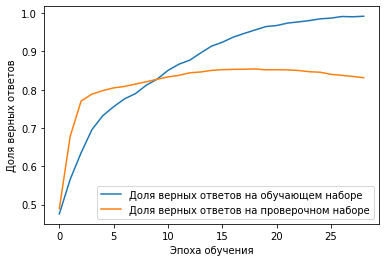

In [ ]:
# график прогрессии обучения нейросети в Matplotlib
plt.plot(view_sem.history['auc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(view_sem.history['val_auc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='best')
plt.show()

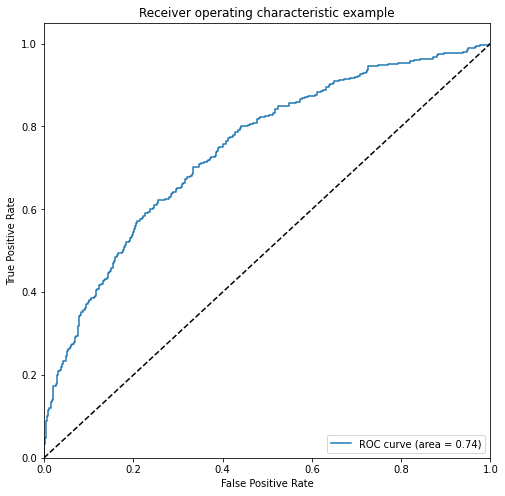

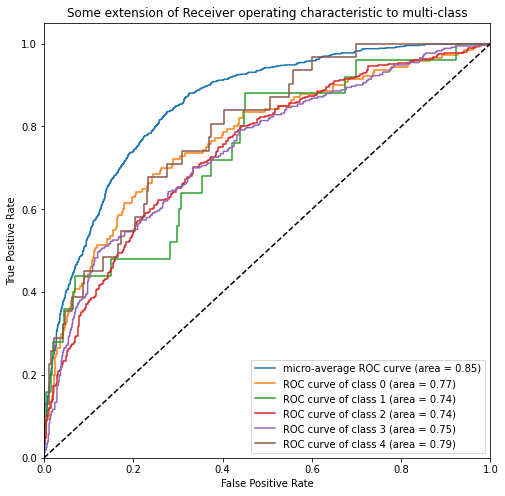

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_sem_train.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_sem_test[:, i], test_predictions_baseline[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_sem_test.ravel(), test_predictions_baseline.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(8,8))
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_predictions_baseline = model_sem.predict(x_sem_train, batch_size=batch_size)
test_predictions_baseline = model_sem.predict(x_sem_test, batch_size=batch_size)

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model_sem.evaluate(x_sem_test, y_sem_test, verbose=1, return_dict=True)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores['auc'] * 100, 4), "%", sep="")

31/31 [==============================] - 0s 4ms/step - loss: 0.3463 - auc: 0.8538
{'loss': 0.34632018208503723, 'auc': 0.8537520170211792}
Доля верных ответов на тестовых данных, в процентах: 85.3752%


In [ ]:
# предсказываем и выводим результат на экран
b = 20
prediction_p = model_sem.predict(X_train_zero[b, None])
print(prediction_p.round(1))
print(y_train_all[b])

[[0.1 0.  0.1 0.9 0. ]]
[0 0 0 1 0]


In [ ]:
# сохраняем веса
model_sem.save_weights('/content/drive/My Drive/Colab Notebooks/NLP course/model_sem.h5')

# **Рекуррентные сети очень хорошо себя показывают при решении задач с текстом. Главное правильно понять задачу, и применить правильные методы. Не стоит перегружать сеть большими параметрами, слоями и сложностью архитектуры если она показывает достаточную точность**